In [ ]:
#Codeblock 0 - installation of packages that are needed
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 16.2 MB/s eta 0:00:00


In [ ]:
#Codeblock 1 - importing all necessary packages
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import random
import re
import io
#Codeline 1a-importing transformers
import transformers
#Codeline 1b-importing logging to capture and store messgaes
from transformers import logging
#Codeline 1c-in the logging module of transformers, this library 
#sets the verbosity level for log messages to display errors
logging.set_verbosity_error()
#Codeline 1d-setting the device to run on cpu
# DEVICE
device = torch.device("cpu")

In [ ]:
#Codeblock 2 - importing all data
#Codeline 2a - opening the json file
f = open('/content/gdrive/MyDrive/data.json')
#Codeline 2b - storing json file to variable - data
data = json.load(f)

In [ ]:
#Codeblock 3 - importing training data
#Codeline 3a - opening the training data created into dataframe
# The dataset I've created
df = pd.read_csv('/content/gdrive/MyDrive/chat_train.csv')
df.head()

,text,label
0,What time of day is it,date
1,What day is it?,date
2,What is the month,date
3,How is Sunday going,date
4,I have to sign off,goodbye


In [ ]:
#Codeline 3b
df['label'].value_counts()

greeting    16
age         10
date         7
goodbye      7
name         7
Name: label, dtype: int64

In [ ]:
#Codeblock 4 - Encoding labels
#Codeline 4a - Encoding the labels using LabelEncoder
# Encoding the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
#Codeline 4b - Checking the distribution of the labels
#for 6 categories - 0,1,2,3,4,5
# Checking distribution
df['label'].value_counts(normalize = True)

3    0.333333
0    0.208333
1    0.145833
2    0.145833
4    0.145833
5    0.020833
Name: label, dtype: float64

In [ ]:
#Codeblock 5 - Splitting as the train text and train label
train_text, train_labels = df['text'], df['label']

In [ ]:
#Codeblock 6 - Trying bert model
# bert-base-uncased model

# from transformers import AutoModel, BertTokenizerFast
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# bert = AutoModel.from_pretrained('bert-base-uncased')

In [ ]:
#Codeblock 7 - Trying roberta model
# roberta-base model

# from transformers import RobertaTokenizer, RobertaModel
# # Load the Roberta tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# # Import Roberta pretrained model
# bert = RobertaModel.from_pretrained('roberta-base')

In [ ]:
#Codeblock 8 - Trying distilbert model
# distilbert-base-uncased model
#Codeline 8a - importing necessary packages
from transformers import DistilBertTokenizer, DistilBertModel
#Codeline 8b - loading tokenizer from pretrained model to variable tokenizer
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#Codeline 8c - importing pretrained model to variable bert
# Import pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
#Codeblock 9 - Encoding
#Codeline 9a - Define some text
text = ["this is a bert model.", "some test sentence"]
#Codeline 9b - Encode the text using tokenizer and print it
# Encode the text
encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
print(encoded_input)

{'input_ids': tensor([[  101,  2023,  2003,  1037, 14324,  2944,  1012,   102],
        [  101,  2070,  3231,  6251,   102,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0]])}


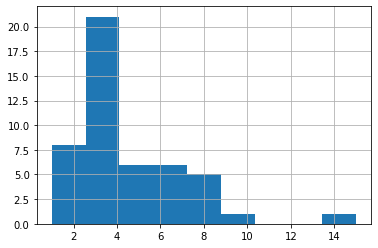

In [ ]:
#Codeblock 10 - Define sequence length
#Codeline 10a - Based on length of train_text words, find sequence length
seq_len = [len(i.split()) for i in train_text]
#Codeline 10b - Create distribution of sequence length
pd.Series(seq_len).hist(bins = 9)
#Codeline 10c - Select the maximum sequence length as 9
# Based on the histogram we select max sequence length as 9
max_seq_len = 9

In [ ]:
#Codeblock 11 - Tokenize the sequences in train data
# Tokenization of the sequences in train data

#Codeline 11a - define tokenizer
tokens_train = tokenizer(
#Codeline 11b - make the train_text to a list
    train_text.tolist(),
#Codeline 11c - define maximum length as sequence length
    max_length = max_seq_len,
#Codeline 11d - define the padding
    padding='longest',
#Codeline 11e - define truncation
    truncation=True,
#Codeline 11f - return the token_type_ids
    return_token_type_ids=False
)

In [ ]:
#Codeblock 12 - Define train sequence, attention mask and target as tensors
#Codeline 12a- Define train sequence tensor
train_seq = torch.tensor(tokens_train['input_ids'])
#Codeline 12b- Define attention mask tensor
train_mask = torch.tensor(tokens_train['attention_mask'])
#Codeline 12c- Define target tensor
train_y = torch.tensor(train_labels.tolist())


In [ ]:
#Codeblock 13 - Create tensor dataset
#Codeline 13a - importing necessary packages 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#Codeline 13b - defining batch size
batch_size = 16
#Codeline 13c - defining train_data as tensor data set
train_data = TensorDataset(train_seq, train_mask, train_y)
#Codeline 13d - defining train_sampler as RandomSampler
train_sampler = RandomSampler(train_data)
#Codeline 13e - defining dataloader uing train tensor data set. 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


In [ ]:
#Codeblock 14 - define class BERT
class BERT(nn.Module):
    #Codeline 14a - define bert
    def __init__(self, bert):      
        super(BERT, self).__init__()
        self.bert = bert 
        #Codeline 14b - add dropout 
        # Dropout layer
        self.dropout = nn.Dropout(0.2)
        #Codeline 14c - add ReLU 
        # Activation
        self.relu =  nn.ReLU()
        #Codeline 14d - dense layers
        # Dense layer
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,6)
        #Codeline 14e - softmax activation
        # Softmax activation
        self.softmax = nn.LogSoftmax(dim=1)
    #Codeline 14f -  Forward pass for torch   
    # Forward pass for Torch
    def forward(self, sent_id, mask):
        #Codeline 14g - fully connected bert
        # Fully connected
        x = self.bert(sent_id, attention_mask=mask)[0][:,0]
        #Codeline 14h - fc1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        #Codeline 14i - fc2
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        #Codeline 14j - output layer
        # Output layer
        x = self.fc3(x)
        #Codeline 14k - softmax
        # Apply softmax
        x = self.softmax(x)
        #Codeline 14l - return x
        return x
    

In [ ]:
#Codeblock 15 - prevent model weights update for fine tuning
# Prevent model weights update for fine-tuning.
for param in bert.parameters():
      #Codeline 15a - requires_grad=False
      param.requires_grad = False
#Codeline 15b - BERT model        
model = BERT(bert)

#Codeline 15c - Load the bert model into device
# Load the model into device 
model = model.to(device)
#Codeline 15d - summary of model
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT                                                    --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           1,542
├─LogSoftmax: 1-7                                       --
Total 

In [ ]:
#Codeblock 16 - optimizer
# AdamW optimizer


from transformers import AdamW
from torch.optim import AdamW
#Codeline 16a - AdamW optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)


In [ ]:
#Codeblock 17 - computing the class weights
from sklearn.utils.class_weight import compute_class_weight
# Computation of the class weights
#Codeline 17a - compute balanced class weights and print
class_weights = compute_class_weight( class_weight='balanced',
                                  classes=np.unique(train_labels),
                                  y=train_labels )
print(class_weights)


[0.8        1.14285714 1.14285714 0.5        1.14285714 8.        ]


In [ ]:
#Codeblock 18 - Make the class weights to tensor
#Codeline 18a - class weights to tensor, to device
# Class weights to tensor
weights= torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)
#Codeline 18b - define negative log-likelihood as loss function
# Loss function: Negative log-likelihood
cross_entropy = nn.NLLLoss(weight=weights)


In [ ]:
#Codeblock 19 - Define training loss, number of epochs and learning rate
from torch.optim.lr_scheduler import StepLR
#Codeline 19a - Define train_losses list
train_losses=[]
#Codeline 19b - Define number of epochs
# n epochs
n_epochs = 200
#Codeline 19c - Define learning rate with optimizer, step size and gamma value
# learning rate scheduler to improve results
step_lr_sscheduler = StepLR(optimizer, step_size=100, gamma=0.1)


In [ ]:
#Codeblock 20 - Model training
# Model training
def train():
    #Codeline 20a - model train
    model.train()
    #Codeline 20b - define total loss
    total_loss = 0
    #Codeline 20c - define total predictions
    total_predictions=[]
    #Codeline 20d - iterate through train_dataloader
    for step, batch in enumerate(train_dataloader):
        #Codeline 20e - loading the batch into device
        # Load the batch into device
        batch = [r.to(device) for r in batch] 
        sent_id, mask, labels = batch
        #Codeline 20f - Get model predictions for current batch
        # Get model predictions for the current batch
        predictions = model(sent_id, mask)
        #Codeline 20g - find cross-entropy loss
        # Loss between actual and predicted labels
        loss = cross_entropy(predictions, labels)
        #Codeline 20h - Find total loss
        # Add on to the total loss
        total_loss =+ loss.item()
        #Codeline 20i - Backward propagation for gradient calculation
        # Backward propagation for gradient calculation
        loss.backward()
        #Codeline 20j - To prevent from exploding gradients, we set the upper bounding to 1
        # Upper bounding the the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        #Codeline 20k - Reset gradients
        # Reset gradients
        optimizer.zero_grad()
        #Codeline 20l - Prediction using GPU and CPU
        # Predictions usually stored in the GPU (however I use CPU as well). We load onto CPU anyway.
        predictions=predictions.detach().cpu().numpy()
        #Codeline 20m - Predictions to batch 
        # Save predictions of the batch
        total_predictions.append(predictions)
    #Codeline 20n - Calculate average training loss of epoch     
    # Training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    #Codeline 20o -  Concatenate total predictions
    # Predictions -> (n batches, batch_size, n classes)
    # Reshape predictions into -> (n samples, n classes)
    total_predictions  = np.concatenate(total_predictions, axis=0)
    #Codeline 20p - Return print the average loss and predictions
    # Return average loss and predictions
    return avg_loss, total_predictions


In [ ]:
#Codeblock 21 - Training over epochs
#Codeline 21a - iterate over epochs
for epoch in range(n_epochs):
     #Codeline 21b - print the epoch
    print('\n Epoch {:} / {:} \r'.format(epoch + 1, n_epochs))
    #Codeline 21c - Train the model
    # Train model
    train_loss, _ = train()
    #Codeline 21d - Save the training and validation loss
    # Save training and validation loss
    train_losses.append(train_loss)
    #Codeline 21e - deterministic reproducability
    # Deterministicity for reproducibility of the train process for further needs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f'\nLoss: {train_loss:.3f}\r')


 Epoch 1 / 200 

 Epoch 2 / 200 

 Epoch 3 / 200 

 Epoch 4 / 200 

 Epoch 5 / 200 

 Epoch 6 / 200 

 Epoch 7 / 200 

 Epoch 8 / 200 

 Epoch 9 / 200 

 Epoch 10 / 200 

 Epoch 11 / 200 

 Epoch 12 / 200 

 Epoch 13 / 200 

 Epoch 14 / 200 

 Epoch 15 / 200 

 Epoch 16 / 200 

 Epoch 17 / 200 

 Epoch 18 / 200 

 Epoch 19 / 200 

 Epoch 20 / 200 

 Epoch 21 / 200 

 Epoch 22 / 200 

 Epoch 23 / 200 

 Epoch 24 / 200 

 Epoch 25 / 200 

 Epoch 26 / 200 

 Epoch 27 / 200 

 Epoch 28 / 200 

 Epoch 29 / 200 

 Epoch 30 / 200 

 Epoch 31 / 200 

 Epoch 32 / 200 

 Epoch 33 / 200 

 Epoch 34 / 200 

 Epoch 35 / 200 

 Epoch 36 / 200 

 Epoch 37 / 200 

 Epoch 38 / 200 

 Epoch 39 / 200 

 Epoch 40 / 200 

 Epoch 41 / 200 

 Epoch 42 / 200 

 Epoch 43 / 200 

 Epoch 44 / 200 

 Epoch 45 / 200 

 Epoch 46 / 200 

 Epoch 47 / 200 

 Epoch 48 / 200 

 Epoch 49 / 200 

 Epoch 50 / 200 

 Epoch 51 / 200 

 Epoch 52 / 200 

 Epoch 53 / 200 

 Epoch 54 / 200 

 Epoch 55 / 200 

 Epoch 56 / 200 



In [ ]:
#Codeblock 22 - get prediction function

def get_prediction(strin):
    #Codeline 22a - use regex
    strin = re.sub(r'[^a-zA-Z ]+', '', strin)
    test_text = [strin]
    model.eval()
    #Codeline 22b - Tokenizer
    tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    padding='longest',
    truncation=True,
    return_token_type_ids=False
    )
    #Codeline 22c - To tensor inpute ids
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    #Codeline 22d - To tensor attention mask
    test_mask = torch.tensor(tokens_test_data['attention_mask'])
    
    predictions = None
    #Codeline 22e - predictions
    with torch.no_grad():
      predictions = model(test_seq.to(device), test_mask.to(device))
    #Codeline 22f - predictions detach from cpu
    predictions = predictions.detach().cpu().numpy()
    #Codeline 22g - use the argmax function
    predictions = np.argmax(predictions, axis = 1)
    print('Intent:', le.inverse_transform(predictions)[0])
    #Codeline 22h - decode the labels and return
    # Return decoded labels
    return le.inverse_transform(predictions)[0]

In [ ]:
#Codeblock 23 - bot response function
def bot_response(message):
  #Codeline 23a - define result 
  result = ''
  #Codeline 23b - define intent using get_prediction function
  intent = get_prediction(message)
  #Codeline 23c - search for tag matching intent   
  for i in data['intents']:
    if i['tag'] == intent:
        #Codeline 23d - from the pool of responses choose random answer
        result = random.choice(i['responses'])
        break

  print(f"Response : {result}")
  #return result

In [ ]:
#Codeblock 24 - test1 a bot_response
bot_response('Hello bot')

Intent: greeting
Response : Hello


In [ ]:
#Codeblock 25 - test2 a bot_response
bot_response('Great, how are you?')

Intent: greeting
Response : How are you doing?


In [ ]:
#Codeblock 26 - test3 a bot_response
bot_response('what is your name')

Intent: name
Response : BOTTT


In [ ]:
#Codeblock 27 - test4 a bot_response
bot_response('What time is it?')

Intent: date
Response : I am available all day


In [ ]:
#Codeblock 28 - test5 a bot_response
bot_response('Farewell!!')

Intent: goodbye
Response : Best regards.
